In [314]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime, timedelta

In [315]:
df = pd.read_csv('bookings.csv', parse_dates=['date','start_time', 'end_time'], index_col=[0])
df.head()

,start_time,end_time,total_time_hours
date,,,
2022-05-10,2022-05-10 11:30:00,2022-05-10 14:30:00,3.0
2022-05-19,2022-05-19 10:00:00,2022-05-19 13:00:00,3.0
2022-06-15,2022-06-15 11:30:00,2022-06-15 14:30:00,3.0
2022-06-27,2022-06-27 10:00:00,2022-06-27 13:00:00,3.0
2022-07-02,2022-07-02 13:00:00,2022-07-02 16:00:00,3.0


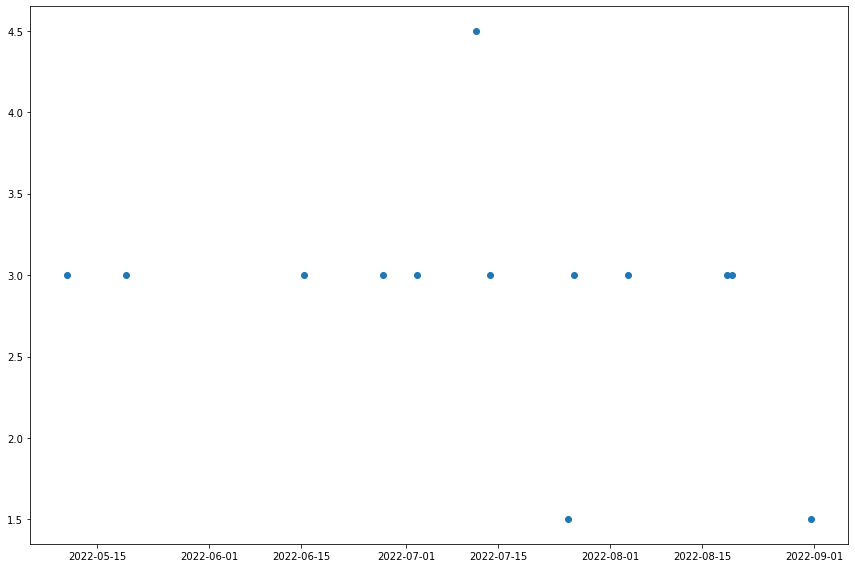

In [316]:
fig = plt.figure(figsize=(12, 8))

plt.scatter(df.start_time, df.total_time_hours)
plt.tight_layout()
plt.show()

In [317]:
df = df.drop(['start_time', 'end_time'], axis=1)
df.head()

,total_time_hours
date,
2022-05-10,3.0
2022-05-19,3.0
2022-06-15,3.0
2022-06-27,3.0
2022-07-02,3.0


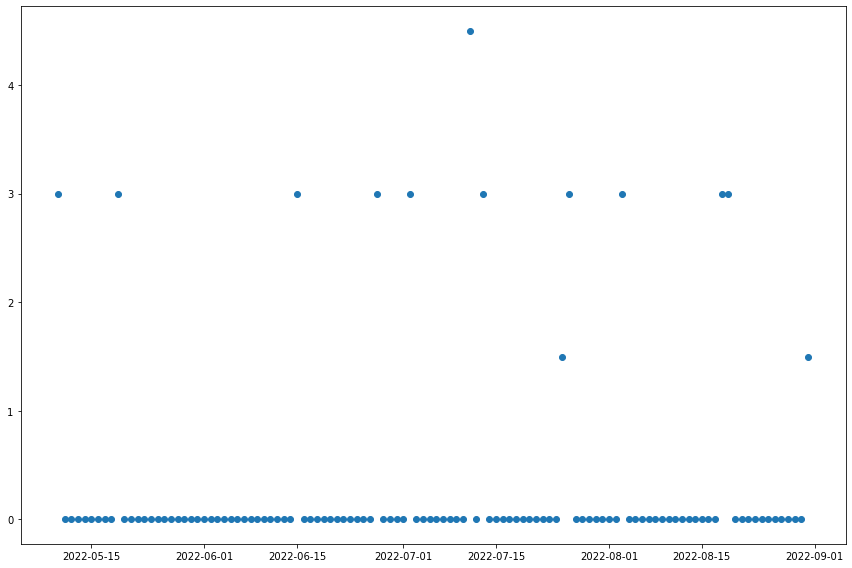

In [318]:
df = df.resample('D').mean().replace(np.nan, 0)
fig = plt.figure(figsize=(12, 8))

plt.scatter(df.index, df)
plt.tight_layout()
plt.show()

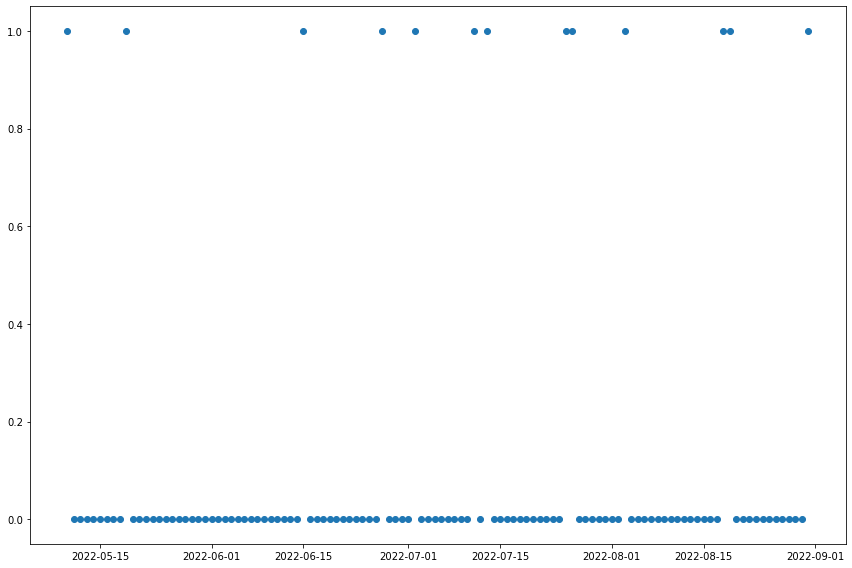

In [319]:
df_binary = df.copy()
df_binary[df_binary > 0] = 1
df_binary.rename(columns={'total_time_hours': 'booked'}, inplace=True)
fig = plt.figure(figsize=(12, 8))

plt.scatter(df_binary.index, df_binary)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

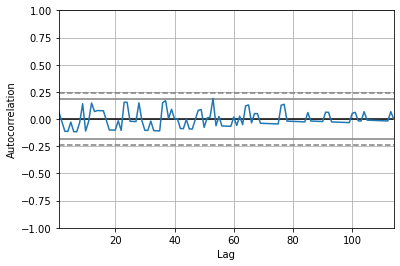

In [320]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_binary['booked'])

In [321]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_binary.booked.to_numpy(), order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  114
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -42.452
Date:                Thu, 01 Sep 2022   AIC                             96.904
Time:                        10:50:47   BIC                            113.268
Sample:                             0   HQIC                           103.544
                                - 114                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6835      0.084     -8.094      0.000      -0.849      -0.518
ar.L2         -0.4904      0.113     -4.340      0.000      -0.712      -0.269
ar.L3         -0.4104      0.159     -2.585      0.0

In [322]:
forecast = model_fit.forecast(steps=31)
forecast

array([0.31650288, 0.29329306, 0.23394347, 0.25287431, 0.39767172,
       0.38610623, 0.33605273, 0.31622654, 0.31187143, 0.33495616,
       0.34624306, 0.33997527, 0.33250319, 0.32922908, 0.33196754,
       0.33565857, 0.33607568, 0.33459441, 0.33334065, 0.33333497,
       0.33407949, 0.33451262, 0.33438787, 0.33407631, 0.33393981,
       0.33403043, 0.33416117, 0.33419294, 0.33414237, 0.33409228,
       0.33408866])

In [323]:
df_binary.iloc[-1]

booked    1.0
Name: 2022-08-31 00:00:00, dtype: float64

In [324]:
dates_forward = [{'date': datetime.today() + timedelta(days=i), 'booked': forecast[i-1]} for i in range(1, len(forecast))]
print(f"Most likely day to to book laundry slot: {dates_forward[np.argmax(forecast)]['date'].date()} ")

Most likely day to to book laundry slot: 2022-09-06 


In [325]:
preds = pd.DataFrame.from_dict(dates_forward).set_index('date')

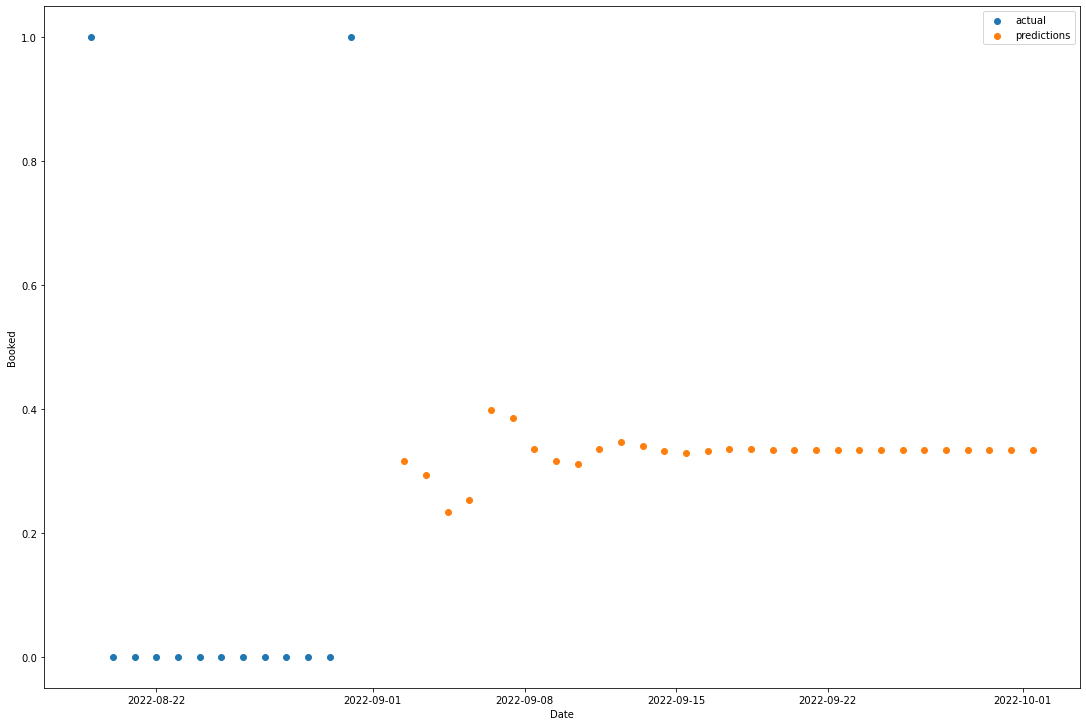

In [326]:
from datetime import date


fig = plt.figure(figsize=(15, 10))

smaller_window = df_binary.index > datetime.today() - timedelta(days=14)

plt.scatter(df_binary[smaller_window].index, df_binary[smaller_window], label='actual')
plt.scatter(preds.index, preds, label='predictions')
plt.tight_layout()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Booked')
plt.show()

In [327]:
from sklearn.linear_model import LogisticRegression

In [328]:
df_rolling = pd.read_csv('bookings.csv', parse_dates=['date','start_time', 'end_time'], index_col=[0])
df_rolling = df_rolling.drop(['start_time', 'end_time'], axis=1)
df_rolling[df_rolling > 0] = 1
df_rolling.head()

,total_time_hours
date,
2022-05-10,1.0
2022-05-19,1.0
2022-06-15,1.0
2022-06-27,1.0
2022-07-02,1.0


In [329]:
df_rolling = df_rolling.reset_index()
df_rolling['days_since_booked'] = (df_rolling.date - np.roll(df_rolling.date, shift=1))
df_rolling.days_since_booked = df_rolling.days_since_booked.apply(lambda x: x.days)
# Change values of first row to 0
df_rolling.days_since_booked.iloc[0] = 0
df_rolling.rename(columns={'total_time_hours': 'booked'}, inplace=True)
# drop first row
df_rolling = df_rolling.drop(df_rolling.index[0])
df_rolling.head()


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,booked,days_since_booked
1,2022-05-19,1.0,9
2,2022-06-15,1.0,27
3,2022-06-27,1.0,12
4,2022-07-02,1.0,5
5,2022-07-11,1.0,9


In [330]:
df_rolling_filled_dates = df_rolling.set_index('date').resample('D').mean()
# increment by 1 each day until the next booking    
for idx, row in df_rolling_filled_dates.iterrows():
    if row.booked == 1:
        counter = 1
    else:
        row.days_since_booked = counter
        counter += 1
df_rolling_filled_dates.replace(np.nan, 0, inplace=True)
df_rolling_filled_dates.head(0)

,booked,days_since_booked
date,,


In [331]:
lr = LogisticRegression()
X, y = df_rolling_filled_dates.days_since_booked.values.reshape(-1, 1), df_rolling_filled_dates.booked.values.ravel()
# split 
N = len(X)
print(N)
X_train, X_test, y_train, y_test = X[:int(N*0.8)], X[int(N*0.8):], y[:int(N*0.8)], y[int(N*0.8):]
print('Length of training set: ', len(X_train))
print('Length of test set: ', len(X_test))
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

105
Length of training set:  84
Length of test set:  21


0.8571428571428571

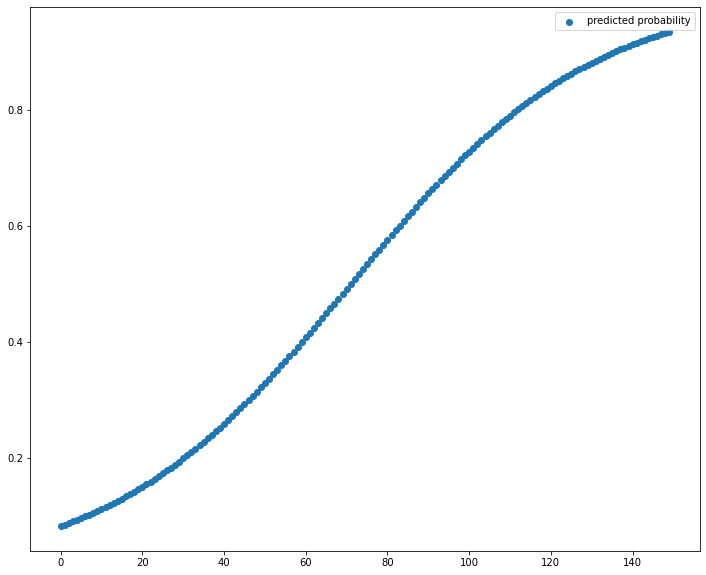

In [332]:
vals = np.arange(0, 150).reshape(-1, 1)
plt.figure(figsize=(12, 10))
plt.scatter(vals, lr.predict_proba(vals)[:, 1], label='predicted probability')
#plt.scatter(vals[y_test==1], y_test[y_test==1], label='actual')
plt.legend()
plt.show()


In [336]:
# get date from the last row of df_rolling_filled_dates
latest_booking_date = df_rolling_filled_dates.index[-1].date()

if latest_booking_date > date.today():
    print('Laundry slot already booked in the future. No need to compute probability.')

dates_forward = [latest_booking_date + timedelta(days=i) for i in range(0, 30)]


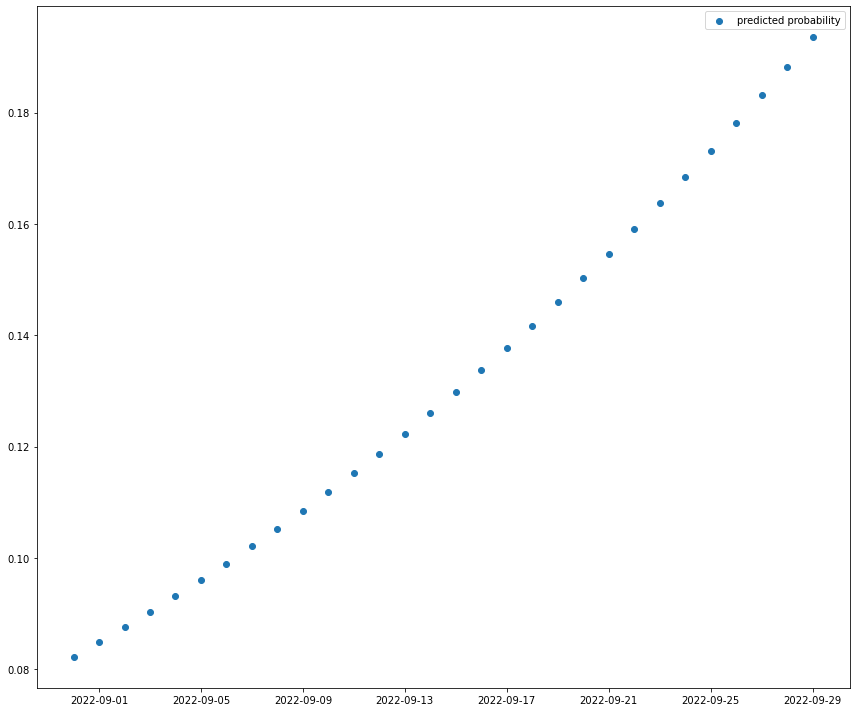

In [342]:
vals = np.arange(0, 30).reshape(-1, 1)
plt.figure(figsize=(12, 10))
plt.scatter(dates_forward, lr.predict_proba(vals)[:, 1], label='predicted probability')
#plt.scatter(vals[y_test==1], y_test[y_test==1], label='actual')
plt.legend()
plt.tight_layout()
plt.savefig('current_predictions.png' ,dpi=150, bbox_inches = "tight")
plt.show()
